# High content quantum yield 

In [96]:
import os
import pandas as pd
import numpy as np


In [98]:
cd C:\Users\hwbst6\DataTime\HCQY\high_content_quantum_yield\tw_hcqy_13102023

C:\Users\hwbst6\DataTime\HCQY\high_content_quantum_yield\tw_hcqy_13102023


In [97]:
pwd

'C:\\Users\\hwbst6\\DataTime\\HCQY\\high_content_quantum_yield\\tw_hcqy_13102023'

## Import data
### UV/Vis and fluorescence data

In [45]:
#script for converting *.xlsx or csv data to a neat UV/vis forma

def spec_import(spec_sht_name):
    #spec_sht_name this is varible for sheet name/experiment number
    #sps_name = "RNA Quantior-003- 5-7-22.xlsx" # this is the spread sheet name if your using a spread sheet
    spec_inp= pd.DataFrame()
    #load in plate reader output uncomment the one you want to use
    try:
        # use this if your reading in from a multisheet excel
        #_inp = pd.read_excel(sps_name, sheet_name = sht_name)

        # use this if your reading from a *csv file
        spec_inp = pd.read_csv(spec_sht_name + '.csv')
    except PermissionError:
        print('The file we are trying to open may be open in another program, please close and try again!')
    try: #transpose and remove some columns, these may need changeing
        spec_inp = pd.DataFrame.transpose(spec_inp)
        spec_inp = spec_inp.drop(axis=1, columns=[0,1,2,3])
        #print(_inp)
    except KeyError:
        print('Check the your input file!') 
    try:    #_inp.sort_index()
        spec_inp = spec_inp.reset_index(drop=True)
        #build well name and remove related columns
        spec_inp.iloc[0:,1] = spec_inp.iloc[0:,1].astype(str)
        spec_inp.iloc[0:,2] = spec_inp.iloc[0:,0].astype(str) + spec_inp.iloc[0:,1].astype(str)
        spec_inp = spec_inp.drop(axis=1, columns=[4,5])
        spec_inp = pd.DataFrame.drop(spec_inp,axis=0, index=0)
        spec_inp.iloc[0,0] = "Well"
    except IndexError:
        print('Check the your input file!')
    try:     
        spec_inp.rename(columns= spec_inp.iloc[0,0:], inplace=True) # set row 0 as col titles
        spec_inp = spec_inp.reset_index(drop=True)
        spec_inp = pd.DataFrame.drop(spec_inp, axis=0, index=0)
        spec_inp = spec_inp.reset_index(drop=True)
    except KeyError:
        print('Check the your input file!')
    try: #output results
        spec_inp.to_csv("hcqy__dat_" + spec_sht_name + ".csv",index=False)
    except PermissionError:
        print('The file we are trying to open may be open in another program, please close and try again!')
    return spec_inp



In [64]:
# Plot and calculate gradients for Chris's optimised plate map
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statistics
from tabulate import tabulate

def plot_calc(abs_inp, flu_inp):
    # experiemnt set up
    ps_lst = ["TPP","C5","C6","C7"]
    exp_points = 5
    num_ps = 4
    num_rep = 4
    abs_wav_len_start = 400
    exc_wav_len = 516

    # setup columns
    hcqy_plot= pd.DataFrame()
    hcqy_plot.insert(0,"PS", range(0,(exp_points*num_ps)))
    for p in range(0,len(ps_lst)):
        hcqy_plot.iloc[(p*exp_points):(p*(exp_points))+5] = ps_lst[p]

    # define excitation wavelength
    exc_col_num = int((exc_wav_len - abs_wav_len_start) / 2)

    # populates experiemnt names and data point names
    # add abs values at excitation wavelength
    hcqy_plot["ex_abs_1"], hcqy_plot["ex_abs_2"], hcqy_plot["ex_abs_3"], hcqy_plot["ex_abs_4"]  = [0, 0, 0, 0]
    hcqy_plot["ex_int_flu_1"], hcqy_plot["ex_int_flu_2"], hcqy_plot["ex_int_flu_3"], hcqy_plot["ex_int_flu_4"]  = [0, 0, 0, 0]

    # populate corrected abs
    #selecting columns to convet to numeric using df.columns
    cols = abs_inp.columns.drop('Well')
    abs_inp[cols] = abs_inp[cols].apply(pd.to_numeric, errors='coerce')

    # add abs values at excitation wavelength
    for x in range(0,(num_rep)):
        for p in range(0,len(ps_lst)):
            #print(p*exp_points)
            n=0 
            g = 0
            if p >= 2:
                g=36
            while n <= (exp_points-1): 
                hcqy_plot.iloc[(p*exp_points+n),x+1] = abs_inp.iloc[(p*exp_points+n+1+p+x*12+g),exc_col_num]
                n = n +1

    #selecting columns to convet to numeric using df.columns
    cols = flu_inp.columns.drop('Well')
    flu_inp[cols] = flu_inp[cols].apply(pd.to_numeric, errors='coerce')

    # populate integrated fluorescence intensities
    for x in range(0,(num_rep)):
        for p in range(0,len(ps_lst)):
            #print(p*exp_points)
            n=0 
            g = 0
            if p >= 2:
                g=36
            while n <= (exp_points-1): 
                hcqy_plot.iloc[(p*exp_points+n),x+5] = flu_inp.iloc[(p*exp_points+n+1+p+x*12+g),1:].sum()
                n = n +1
              
    # set up gradiant data frame with experiemnt by experiemnt possitions
    hcqy_grad = pd.DataFrame()
    hcqy_grad.insert(0,"PS", range(0,(num_rep*num_ps)))
    for p in range(0,len(ps_lst)):
        hcqy_grad.iloc[(p*num_rep):(p*(num_rep))+num_rep] = ps_lst[p]
    hcqy_grad["grad_abs_flu"]  = 0
    hcqy_grad["grad_R^2"]  = 0
    hcqy_grad["grad_intercept"]  = 0
    hcqy_grad["flu_QY"]  = 0


    # populate gradiant data frame
    for p in range(0,len(ps_lst)):
        #per PS
        for x in range(0,(num_rep)):
            #per rep
            x_lr = np.array(hcqy_plot.iloc[p*5:(5+p*5),x+1]).reshape((-1, 1))
            y_lr = np.array(hcqy_plot.iloc[p*5:(5+p*5),x+5])
            qy_grad = LinearRegression().fit(x_lr, y_lr)
            hcqy_grad.iloc[x+p*num_rep,1] =  qy_grad.coef_[0]
            hcqy_grad.iloc[x+p*num_rep,2] =  qy_grad.score(x_lr, y_lr)
            hcqy_grad.iloc[x+p*num_rep,3] =  qy_grad.intercept_

    # QC on gradient data frame

    # prep for QY calc collect standard QY values and check solvents
    # take mean of standard gradient
    st_grad = statistics.mean(hcqy_grad.iloc[0:4,1])

    # calculate QYs move to QY df
    st_qy = 0.1 # check value
    for p in range(1,len(ps_lst)):
        #per PS
        for x in range(0,(num_rep)):
            #per rep
            hcqy_grad.iloc[x+p*num_rep,4] = st_qy*((hcqy_grad.iloc[x+p*num_rep,1])/st_grad)*(1**2/1**2)
    hcqy_qy = pd.DataFrame()
    hcqy_qy.insert(0,"PS", range(0,num_ps-1))
    hcqy_qy["\u03A6x"]  = 0
    hcqy_qy["\u03C3"]  = 0
    hcqy_qy["2\u03C3"]  = 0
    hcqy_qy["% error at \u03C3"]  = 0
    hcqy_qy["% error at 2\u03C3"]  = 0
    for p in range(1,len(ps_lst)):
        hcqy_qy.iloc[(p-1),0] = ps_lst[p]
        hcqy_qy.iloc[(p-1),1] = statistics.mean(hcqy_grad.iloc[p*4:p*4+5,4])
        hcqy_qy.iloc[(p-1),2] = statistics.stdev(hcqy_grad.iloc[p*4:p*4+5,4])
        hcqy_qy.iloc[(p-1),3] = 2 * hcqy_qy.iloc[(p-1),2]
        hcqy_qy.iloc[(p-1),4] = (hcqy_qy.iloc[(p-1),2] / hcqy_qy.iloc[(p-1),1]) * 100
        hcqy_qy.iloc[(p-1),5] = (hcqy_qy.iloc[(p-1),3] / hcqy_qy.iloc[(p-1),1]) * 100
    hcqy_qy = hcqy_qy.reset_index(drop=True)    
    print(tabulate(hcqy_qy, headers=hcqy_qy.columns, tablefmt="github", showindex=False))   

    # generate overarching plots, raw abd vs. int flu labled
    mark_lst = ["o", "v", "h", "p"]
    colour_lst = ["black", "blue", "green", "purple"]
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    
    #loops to generate number of PS * number of repeats plots
    for p in range(0,len(ps_lst)):
        if p == 0 or p == 1:
            px = 0
        else:
            px = 1
        if p == 0 or p == 2:
            py = 0
        else:
            py = 1
        plt.title(f'HCQY for {ps_lst[p]}', pad=5)
        for x in range(0,(num_rep)):
            # plot design
            #plt.title(f'HCQY for {ps_lst[p-1]}', pad=5)
            x_1 = hcqy_plot.iloc[p*5:(5+p*5),x+1]
            y_1 = hcqy_plot.iloc[p*5:(5+p*5),x+5]
            plt.subplot(2, 2, p+1)
            ax[px,py].scatter(x_1, y_1,s=30, facecolors='none', edgecolors=colour_lst[p], linewidths=2.0, marker = mark_lst[x])
            plt.xlim(0,(1.2*max(x_1)))
            plt.ylim(0,(1.2*max(y_1)))
            plt.xlabel("Absorbance")
            plt.ylabel("Integrated FU ")
    fig.tight_layout()
    plt.show()
    return hcqy_plot, exp_points, ps_lst



In [66]:
# QC script

def hcqy_qc(hcqy_plot, exp_points, ps_lst):

    # build QC data frame
    hcqy_qc_df = pd.DataFrame()
    # setup columns
    hcqy_qc_df.insert(0,"PS", range(0,(exp_points*num_ps)))
    for p in range(0,len(ps_lst)):
        hcqy_qc_df.iloc[(p*exp_points):(p*(exp_points))+5] = ps_lst[p]


    # check replicates with standard devation from average set thresh hold
    print(hcqy_qc_df)

    # populate QC data frame

    # Check linear plots with R^2 set thresh hold 

    # populate QC data frame

    # check error in QY set average 

    # populate QC data frame 

    # build QC report per PS

    # save QC report as *.CSV
    
    return



| PS   |        Φx |          σ |         2σ |   % error at σ |   % error at 2σ |
|------|-----------|------------|------------|----------------|-----------------|
| C5   | 0.095341  | 0.0046982  | 0.0093964  |        4.92779 |         9.85557 |
| C6   | 0.0921505 | 0.00355788 | 0.00711577 |        3.86095 |         7.7219  |
| C7   | 0.0925725 | 0.00552937 | 0.0110587  |        5.97302 |        11.946   |


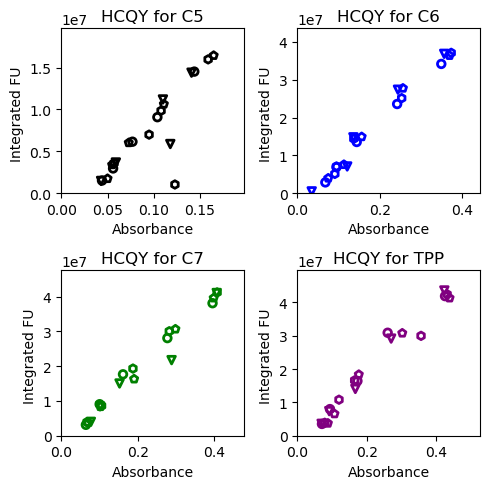

NameError: name 'hcqy_plot' is not defined

In [68]:
#importing spectra UV/vis and fluorescence
# this will form the class

abs_input = "TRno4895" # name of abs input file from clario star

flu_input = "TRno4897" # name of abs input file from clario star

abs_inp = spec_import(abs_input)
flu_inp = spec_import(flu_input)

#print(abs_inp.head(3))
#print(flu_inp.head(3))

plot_calc(abs_inp, flu_inp)

hcqy_qc(hcqy_plot, exp_points, ps_lst)

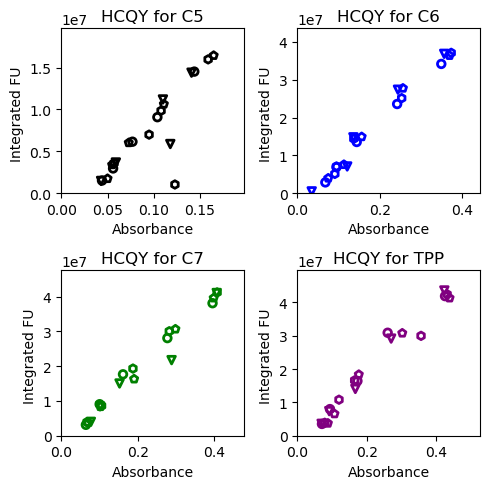

Table 1, Quantum yield values
| PS   |        Φx |          σ |         2σ |   % error at σ |   % error at 2σ |
|------|-----------|------------|------------|----------------|-----------------|
| C5   | 0.095341  | 0.0046982  | 0.0093964  |        4.92779 |         9.85557 |
| C6   | 0.0921505 | 0.00355788 | 0.00711577 |        3.86095 |         7.7219  |
| C7   | 0.0925725 | 0.00552937 | 0.0110587  |        5.97302 |        11.946   |

Table 2, QC report
| PS   | pippetteing error   | plot linearity   | Φx % error   |
|------|---------------------|------------------|--------------|
| TPP  | True                | False            |              |
| C5   | True                | False            | True         |
| C6   | True                | False            | True         |
| C7   | True                | False            | False        |
     PS  ex_abs_1  ex_abs_2  ex_abs_3  ex_abs_4  ex_int_flu_1  ex_int_flu_2  \
0   TPP     0.144     0.141     0.159     0.165      14524192      1439

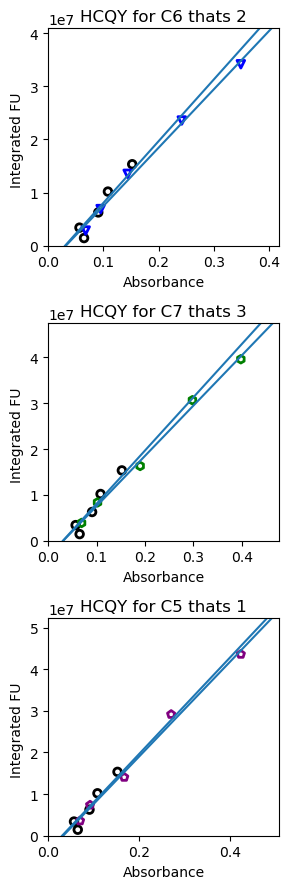

In [386]:
class hcqy_exp_to_value():
    
    
    def __init__(self, abs_input, flu_input, st_qy, ps_lst, exp_points, num_ps, num_rep, abs_wav_len_start, exc_wav_len):
        self.abs_input = abs_input
        self.abs_input = abs_input
        self.st_qy = st_qy
        self.ps_lst = ps_lst
        self.exp_points = exp_points
        self.num_ps = num_ps # this can be replaced with len(self.ps_lst) ?
        self.num_rep = num_rep
        self.abs_wav_len_start = abs_wav_len_start # this could be calculated
        self.exc_wav_len = exc_wav_len
        #self.hcqy_plot = hcqy_plot
        
    def spec_import(self, spec_sht_name):
        #spec_sht_name this is varible for sheet name/experiment number
        #sps_name = "RNA Quantior-003- 5-7-22.xlsx" # this is the spread sheet name if your using a spread sheet
        spec_inp= pd.DataFrame()
        #load in plate reader output uncomment the one you want to use
        try:
            # use this if your reading in from a multisheet excel
            #_inp = pd.read_excel(sps_name, sheet_name = sht_name)

            # use this if your reading from a *csv file
            spec_inp = pd.read_csv(spec_sht_name + '.csv')
        except PermissionError:
            print('The file we are trying to open may be open in another program, please close and try again!')
        try: #transpose and remove some columns, these may need changeing
            spec_inp = pd.DataFrame.transpose(spec_inp)
            spec_inp = spec_inp.drop(axis=1, columns=[0,1,2,3])
            #print(_inp)
        except KeyError:
            print('Check the your input file!') 
        try:    #_inp.sort_index()
            spec_inp = spec_inp.reset_index(drop=True)
            #build well name and remove related columns
            spec_inp.iloc[0:,1] = spec_inp.iloc[0:,1].astype(str)
            spec_inp.iloc[0:,2] = spec_inp.iloc[0:,0].astype(str) + spec_inp.iloc[0:,1].astype(str)
            spec_inp = spec_inp.drop(axis=1, columns=[4,5])
            spec_inp = pd.DataFrame.drop(spec_inp,axis=0, index=0)
            spec_inp.iloc[0,0] = "Well"
        except IndexError:
            print('Check the your input file!')
        try:     
            spec_inp.rename(columns= spec_inp.iloc[0,0:], inplace=True) # set row 0 as col titles
            spec_inp = spec_inp.reset_index(drop=True)
            spec_inp = pd.DataFrame.drop(spec_inp, axis=0, index=0)
            spec_inp = spec_inp.reset_index(drop=True)
        except KeyError:
            print('Check the your input file!')
        try: #output results
            spec_inp.to_csv("hcqy__dat_" + spec_sht_name + ".csv",index=False)
            #print(spec_inp)
        except PermissionError:
            print('The file we are trying to open may be open in another program, please close and try again!')
        return spec_inp

    def plot_calc(self, abs_inp, flu_inp):
        # experiemnt set up
        ps_lst = ["TPP","C5","C6","C7"]
        exp_points = 5
        num_ps = 4
        num_rep = 4
        abs_wav_len_start = 400
        exc_wav_len = 516

        # setup columns
        hcqy_plot= pd.DataFrame()
        hcqy_plot.insert(0,"PS", range(0,(exp_points*num_ps)))
        for p in range(0,len(ps_lst)):
            hcqy_plot.iloc[(p*exp_points):(p*(exp_points))+5] = ps_lst[p]

        # define excitation wavelength
        exc_col_num = int((exc_wav_len - abs_wav_len_start) / 2)

        # populates experiemnt names and data point names
        # add abs values at excitation wavelength
        hcqy_plot["ex_abs_1"], hcqy_plot["ex_abs_2"], hcqy_plot["ex_abs_3"], hcqy_plot["ex_abs_4"]  = [0, 0, 0, 0]
        hcqy_plot["ex_int_flu_1"], hcqy_plot["ex_int_flu_2"], hcqy_plot["ex_int_flu_3"], hcqy_plot["ex_int_flu_4"]  = [0, 0, 0, 0]

        # populate corrected abs
        #selecting columns to convet to numeric using df.columns
        cols = abs_inp.columns.drop('Well')
        abs_inp[cols] = abs_inp[cols].apply(pd.to_numeric, errors='coerce')

        # add abs values at excitation wavelength
        for x in range(0,(num_rep)):
            for p in range(0,len(ps_lst)):
                #print(p*exp_points)
                n=0 
                g = 0
                if p >= 2:
                    g=36
                while n <= (exp_points-1): 
                    hcqy_plot.iloc[(p*exp_points+n),x+1] = abs_inp.iloc[(p*exp_points+n+1+p+x*12+g),exc_col_num]
                    n = n +1

        #selecting columns to convet to numeric using df.columns
        cols = flu_inp.columns.drop('Well')
        flu_inp[cols] = flu_inp[cols].apply(pd.to_numeric, errors='coerce')

        # populate integrated fluorescence intensities
        for x in range(0,(num_rep)):
            for p in range(0,len(ps_lst)):
                #print(p*exp_points)
                n=0 
                g = 0
                if p >= 2:
                    g=36
                while n <= (exp_points-1): 
                    hcqy_plot.iloc[(p*exp_points+n),x+5] = flu_inp.iloc[(p*exp_points+n+1+p+x*12+g),1:].sum()
                    n = n +1

       
        # generate overarching plots, raw abd vs. int flu labled
        mark_lst = ["o", "v", "h", "p"]
        colour_lst = ["black", "blue", "green", "purple"]
        fig, ax = plt.subplots(2, 2, figsize=(5,5))

        #loops to generate number of PS * number of repeats plots
        for p in range(0,len(ps_lst)):
            if p == 0 or p == 1:
                px = 0
            else:
                px = 1
            if p == 0 or p == 2:
                py = 0
            else:
                py = 1
            plt.title(f'HCQY for {ps_lst[p]}', pad=5)
            for x in range(0,(num_rep)):
                # plot design
                #plt.title(f'HCQY for {ps_lst[p-1]}', pad=5)
                x_1 = hcqy_plot.iloc[p*5:(5+p*5),x+1]
                y_1 = hcqy_plot.iloc[p*5:(5+p*5),x+5]
                plt.subplot(2, 2, p+1)
                ax[px,py].scatter(x_1, y_1,s=30, facecolors='none', edgecolors=colour_lst[p], linewidths=2.0, marker = mark_lst[x])
                plt.xlim(0,(1.2*max(x_1)))
                plt.ylim(0,(1.2*max(y_1)))
                plt.xlabel("Absorbance")
                plt.ylabel("Integrated FU ")
        fig.tight_layout()
        plt.show()
        return hcqy_plot #, exp_points, ps_lst

        # QC script
        
    def hcqy_grads(self, hcqy_plot, exp_points, ps_lst, num_ps, num_rep):
         # set up gradiant data frame with experiemnt by experiemnt possitions
        hcqy_grad = pd.DataFrame()
        hcqy_grad.insert(0,"PS", range(0,(num_rep*num_ps)))
        for p in range(0,len(ps_lst)):
            hcqy_grad.iloc[(p*num_rep):(p*(num_rep))+num_rep] = ps_lst[p]
        hcqy_grad["grad_abs_flu"]  = 0
        hcqy_grad["grad_R^2"]  = 0
        hcqy_grad["grad_intercept"]  = 0
        hcqy_grad["flu_QY"]  = 0


        # populate gradiant data frame
        for p in range(0,len(ps_lst)):
            #per PS
            for x in range(0,(num_rep)):
                #per rep
                x_lr = np.array(hcqy_plot.iloc[p*5:(5+p*5),x+1]).reshape((-1, 1))
                y_lr = np.array(hcqy_plot.iloc[p*5:(5+p*5),x+5])
                qy_grad = LinearRegression().fit(x_lr, y_lr)
                hcqy_grad.iloc[x+p*num_rep,1] =  qy_grad.coef_[0]
                hcqy_grad.iloc[x+p*num_rep,2] =  qy_grad.score(x_lr, y_lr)
                hcqy_grad.iloc[x+p*num_rep,3] =  qy_grad.intercept_

        # QC on gradient data frame
        
        return hcqy_grad

    def hcqy_qy_calc(self, hcqy_grad, exp_points, ps_lst, num_ps, num_rep):
        # prep for QY calc collect standard QY values and check solvents
        # take mean of standard gradient
        st_grad = statistics.mean(hcqy_grad.iloc[0:4,1])

        # calculate QYs move to QY df
        st_qy = 0.1 # check value
        for p in range(1,len(ps_lst)):
            #per PS
            for x in range(0,(num_rep)):
                #per rep
                hcqy_grad.iloc[x+p*num_rep,4] = st_qy*((hcqy_grad.iloc[x+p*num_rep,1])/st_grad)*(1**2/1**2)
        hcqy_qy = pd.DataFrame()
        hcqy_qy.insert(0,"PS", range(0,num_ps-1))
        hcqy_qy["\u03A6x"]  = 0
        hcqy_qy["\u03C3"]  = 0
        hcqy_qy["2\u03C3"]  = 0
        hcqy_qy["% error at \u03C3"]  = 0
        hcqy_qy["% error at 2\u03C3"]  = 0
        for p in range(1,len(ps_lst)):
            hcqy_qy.iloc[(p-1),0] = ps_lst[p]
            hcqy_qy.iloc[(p-1),1] = statistics.mean(hcqy_grad.iloc[p*4:p*4+5,4])
            hcqy_qy.iloc[(p-1),2] = statistics.stdev(hcqy_grad.iloc[p*4:p*4+5,4])
            hcqy_qy.iloc[(p-1),3] = 2 * hcqy_qy.iloc[(p-1),2]
            hcqy_qy.iloc[(p-1),4] = (hcqy_qy.iloc[(p-1),2] / hcqy_qy.iloc[(p-1),1]) * 100
            hcqy_qy.iloc[(p-1),5] = (hcqy_qy.iloc[(p-1),3] / hcqy_qy.iloc[(p-1),1]) * 100
        hcqy_qy = hcqy_qy.reset_index(drop=True)
        print("Table 1, Quantum yield values")
        print(tabulate(hcqy_qy, headers=hcqy_qy.columns, tablefmt="github", showindex=False))
        try: #output results
            hcqy_qy.to_csv("hcqy_values_" + abs_input + "_" + abs_input + ".csv",index=False)
        except PermissionError:
            print('The file we are trying to open may be open in another program, please close and try again!')
        return hcqy_qy


    def hcqy_qc(self, hcqy_plot, hcqy_qy, hcqy_grad, exp_points, ps_lst, num_ps, num_rep):
        # global QC frame
        hcqy_qc_df = pd.DataFrame()
        # setup columns
        hcqy_qc_df.insert(0,"PS", range(0,num_ps))
        for p in range(0,len(ps_lst)):
            hcqy_qc_df.iloc[p] = ps_lst[p]
        # build replicate data frame
        hcqy_rep_df = pd.DataFrame()
        # setup columns
        hcqy_rep_df.insert(0,"PS", range(0,(exp_points*num_ps)))
        for p in range(0,len(ps_lst)):
            hcqy_rep_df.iloc[(p*exp_points):(p*(exp_points))+5] = ps_lst[p]


        # check replicates with standard devation from average set thresh hold
        hcqy_rep_df["abs_mean"]  = 0
        hcqy_rep_df["abs_\u03C3"]  = 0
        hcqy_rep_df["abs_2\u03C3"]  = 0
        hcqy_rep_df["% error at \u03C3"]  = 0
        hcqy_rep_df["% error at 2\u03C3"]  = 0
        for x in range(0,(exp_points)):
            #per PS
            for p in range(0,(len(ps_lst))):
                #per rep
                hcqy_rep_df.iloc[x+p*exp_points,1] = statistics.mean(hcqy_plot.iloc[x+p*exp_points, 1:5])
                hcqy_rep_df.iloc[x+p*exp_points,2] = statistics.stdev(hcqy_plot.iloc[x+p*exp_points, 1:5])
                hcqy_rep_df.iloc[x+p*exp_points,3] = 2 * hcqy_rep_df.iloc[x+p*exp_points,2]
                hcqy_rep_df.iloc[x+p*exp_points,4] = (hcqy_rep_df.iloc[x+p*exp_points,2] / hcqy_rep_df.iloc[x+p*exp_points,1]) * 100
                hcqy_rep_df.iloc[x+p*exp_points,5] = (hcqy_rep_df.iloc[x+p*exp_points,3] / hcqy_rep_df.iloc[x+p*exp_points,1]) * 100
                

        # populate QC data frame
        
        hcqy_qc_df["pippetteing error"]  = False
        for p in range(0,(len(ps_lst))): 
            if max(hcqy_rep_df.iloc[p*exp_points:p*exp_points + 5,5]) >= 10: # thresh hold set at 10%
                hcqy_qc_df.iloc[p,1]= True
        
        # Check linear plots with R^2 set thresh hold   # populate QC data frame
        
        hcqy_qc_df["plot linearity"]  = True
        for p in range(0,(len(ps_lst))): 
            if min(hcqy_grad.iloc[p*num_rep:p*num_rep + 4,2]) <= 0.99: # thresh hold set at 10%
                hcqy_qc_df.iloc[p,2]= False
       
        
        # check error in QY set average and populate QC data frame
        hcqy_qc_df["\u03A6x % error"]  = ""
        for p in range(1,(len(ps_lst))): 
            if hcqy_qy.iloc[p-1,5] >= 10: # thresh hold set at 10%
                hcqy_qc_df.iloc[p,3]= False
            else:
                hcqy_qc_df.iloc[p,3]= True
        # save QC report as *.CSV
        print("\nTable 2, QC report")
        print(tabulate(hcqy_qc_df, headers=hcqy_qc_df.columns, tablefmt="github", showindex=False))
        try: #output results
            hcqy_qc_df.to_csv("hcqy_qc_" + abs_input + "_" + abs_input + ".csv",index=False)
        except PermissionError:
            print('The file we are trying to open may be open in another program, please close and try again!')
        return

    def hcqy_prod_plot(self, hcqy_plot, hcqy_qy, hcqy_grad, exp_points, ps_lst, num_ps, num_rep):
        # make plot data frame
        
        hcqy_plot_df = pd.DataFrame()
    
        hcqy_plot_df.insert(0,"PS", range(0,(exp_points*num_ps)))
        for p in range(0,len(ps_lst)):
            hcqy_plot_df.iloc[(p*exp_points):(p*(exp_points))+5] = ps_lst[p]
        hcqy_plot_df["rep abs"]  = 0
        hcqy_plot_df["rep flu"]  = 0
        hcqy_plot_df["line flu"]  = 0
        
           
        # populate control
        for x in range(0,(exp_points)):
            hcqy_plot_df.iloc[x,1] = statistics.mean(hcqy_plot.iloc[x,1:5])
            hcqy_plot_df.iloc[x,2] = statistics.mean(hcqy_plot.iloc[x,5:9])
            hcqy_plot_df.iloc[x,3] = hcqy_plot_df.iloc[x,1] * statistics.mean(hcqy_grad.iloc[0:4,1]) + statistics.mean(hcqy_grad.iloc[0:4,3])
        # populate representative x selecting repeat with best R^2
        for p in range(1,(len(ps_lst))): 
            for x in range(0,(exp_points)):
                hcqy_plot_df.iloc[x + p * exp_points,1] = hcqy_plot.iloc[x + p * exp_points,1 + ((pd.Series(hcqy_grad.iloc[p*num_rep:p*num_rep + 4,2]).idxmax()) - p * num_rep)]
                hcqy_plot_df.iloc[x + p * exp_points,2] = hcqy_plot.iloc[x + p * exp_points,5 + ((pd.Series(hcqy_grad.iloc[p*num_rep:p*num_rep + 4,2]).idxmax()) - p * num_rep)]        
                hcqy_plot_df.iloc[x + p * exp_points,3] = hcqy_plot_df.iloc[x + p * exp_points,1] * hcqy_grad.iloc[pd.Series(hcqy_grad.iloc[p*num_rep:p*num_rep + 4,2]).idxmax(),1] + hcqy_grad.iloc[pd.Series(hcqy_grad.iloc[p*num_rep:p*num_rep + 4,2]).idxmax(),3]
        #print(hcqy_grad)
        print(hcqy_plot)
        # setup columns
        #hcqy_qc_df.insert(0,"PS", range(0,num_ps))
        # generate overarching plots, raw abd vs. int flu labled
        mark_lst = ["o", "v", "h", "p"]
        colour_lst = ["black", "blue", "green", "purple"]
        fig, ax = plt.subplots(3, 1, figsize=(3,9))

        #loops to generate number of PS * number of repeats plots
        for p in range(1,len(ps_lst)):
            
            plt.title(f'HCQY for {ps_lst[p]} thats {p}', pad=5)
            
            x_1 = hcqy_plot_df.iloc[0:5,1]
            y_1 = hcqy_plot_df.iloc[0:5,2]
            x_2 = hcqy_plot_df.iloc[p*5:(5+p*5),1]
            y_2 = hcqy_plot_df.iloc[p*5:(5+p*5),2]
            y_3 = hcqy_plot_df.iloc[0:5,3]
            y_4 = hcqy_plot_df.iloc[p*5:(5+p*5),3]
            plt.subplot(3, 1, p)
            ax[p-1].scatter(x_1, y_1,s=30, facecolors='none', edgecolors=colour_lst[0], linewidths=2.0, marker = mark_lst[0])
            ax[p-1].axline(xy1 = (hcqy_plot_df.iloc[0,1],hcqy_plot_df.iloc[0,3]), xy2 = (hcqy_plot_df.iloc[4,1],hcqy_plot_df.iloc[4,3]))
            ax[p-1].scatter(x_2, y_2,s=30, facecolors='none', edgecolors=colour_lst[p], linewidths=2.0, marker = mark_lst[p])
            ax[p-1].axline(xy1 = (hcqy_plot_df.iloc[(p*5),1],hcqy_plot_df.iloc[(p*5),3]), xy2 = (hcqy_plot_df.iloc[(4+p*5),1],hcqy_plot_df.iloc[(4+p*5),3]))
            plt.xlim(0,(1.2*max(x_2)))
            plt.ylim(0,(1.2*max(y_2)))
            plt.xlabel("Absorbance")
            plt.ylabel("Integrated FU ")
        fig.tight_layout()
        plt.show()
        return
    
def analyse_hcqy():
    # use input
    abs_input = "TRno4895" # name of abs input file from clario star
    C = "TRno4897" # name of abs input file from clario star
    st_qy = 0.1 # check value
    ps_lst = ["TPP","C5","C6","C7"]
    exp_points = 5
    num_ps = 4
    num_rep = 4
    abs_wav_len_start = 400
    exc_wav_len = 516

    val_calc = hcqy_exp_to_value(abs_input, flu_input, st_qy, ps_lst, exp_points, num_ps, num_rep, abs_wav_len_start, exc_wav_len)
    abs_inp = hcqy_exp_to_value.spec_import(val_calc, abs_input)
    flu_inp = hcqy_exp_to_value.spec_import(val_calc, flu_input)
    #flu_inp = spec_import(flu_input)

    #print(abs_inp.head(3))
    #print(flu_inp.head(3))

    plot_one = hcqy_exp_to_value.plot_calc(val_calc,abs_inp, flu_inp)
    
    plot_grd = hcqy_exp_to_value.hcqy_grads(val_calc, plot_one, exp_points, ps_lst, num_ps, num_rep)

    plot_qy = hcqy_exp_to_value.hcqy_qy_calc(val_calc, plot_grd, exp_points, ps_lst, num_ps, num_rep)
    
    qc_one = hcqy_exp_to_value.hcqy_qc(val_calc, plot_one, plot_qy, plot_grd, exp_points, ps_lst, num_ps, num_rep)
    
    qc_one = hcqy_exp_to_value.hcqy_prod_plot(val_calc, plot_one, plot_qy, plot_grd, exp_points, ps_lst, num_ps, num_rep)

    #hcqy_qc(plot_calc(abs_inp, flu_inp))
    return


analyse_hcqy()